In [1]:
! python --version

Python 3.10.2


# Traning Deep Neural Networks on a GPU

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [3]:
dataset = MNIST(
    root='data/',
    download=True,
    transform=ToTensor()
)

In [4]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
img, label = dataset[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

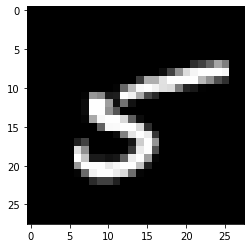

In [6]:
%matplotlib inline
x = 145
img, label = dataset[x]
plt.imshow(img[0], cmap='gray')

In [7]:
def split_indices(n, val_pct):
    n_val = int(val_pct * n) # to get a int val
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val] # training, validation

In [8]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)
print(len(train_indices), len(val_indices))
print(f'Sample val indices: {val_indices[:20]}')

48000 12000
Sample val indices: [58127 13119 52465 39738 48613 32527 14468 28412 10175  4408 41066 31041
 40067 45963 25061 21617 14459 30725 57327 12498]


In [9]:
batch_size = 100

# traning sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(
    dataset,
    batch_size,
    sampler=train_sampler
)

# validation sampler and data loader
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(
    dataset,
    batch_size,
    sampler=valid_sampler
)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
for xb, yb in train_dl:
    xb = xb.view(xb.size(0), -1)
    print(f'xb.shape = {xb.shape}')
    print(f'yb.shape = {yb.shape}')
    break

xb.shape = torch.Size([100, 784])
yb.shape = torch.Size([100])


In [12]:
t = torch.tensor([0, .2, -0.3])
F.relu(t)

tensor([0.0000, 0.2000, 0.0000])

In [13]:
class MnistModel(nn.Module):
    """Feedforward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, xb):
        # Flatten the image tensor
        xb = xb.view(xb.size(0), -1)
        # get intermindate ouput using hidden layer
        out = self.linear1(xb)
        # apply activation function
        out = F.relu(out)
        #get predictions using output layer
        out = self.linear2(out)
        return out


In [14]:
input_size = 784
num_classes = 10

model = MnistModel(
    in_size=input_size,
    hidden_size=32,
    out_size=num_classes
)

In [15]:
for t in model.parameters():
    print(t.shape) # stored in transposed format

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [16]:
for images, labels in train_dl:
    print(f'images.shape = {images.shape}')
    print(f'labels.shape = {labels.shape}')
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print(f'Loss: {loss.item()}')
    break

print(f'output.shape: {outputs.shape}')
print(f'Sample outputs: \n{outputs[:2].data}')
print(f'Softmax Sample outputs: \n{F.softmax(outputs, dim = 1)[:2].data}')

images.shape = torch.Size([100, 1, 28, 28])
labels.shape = torch.Size([100])
Loss: 2.2935950756073
output.shape: torch.Size([100, 10])
Sample outputs: 
tensor([[ 0.0156, -0.1521,  0.0318, -0.0039, -0.1964,  0.0683, -0.0979,  0.0378,
          0.0446,  0.1415],
        [ 0.0273, -0.0708,  0.0914, -0.0745, -0.1464,  0.0789, -0.1194, -0.0330,
         -0.0257,  0.1714]])
Softmax Sample outputs: 
tensor([[0.1022, 0.0864, 0.1039, 0.1002, 0.0827, 0.1077, 0.0912, 0.1045, 0.1052,
         0.1159],
        [0.1033, 0.0937, 0.1102, 0.0933, 0.0869, 0.1088, 0.0892, 0.0973, 0.0980,
         0.1193]])


In [17]:
torch.cuda.is_available()

True

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
def to_device(data, device):
    """Move tensor(s) to choosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [21]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


In [23]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

        

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [25]:
len(train_dl), len(valid_dl)

(480, 120)

In [26]:
for xb, yb in valid_dl:
    print(f'xb.device: {xb.device}')
    print(f'yb: {yb}')
    break

xb.device: cuda:0
yb: tensor([6, 7, 3, 3, 9, 6, 7, 3, 1, 8, 8, 3, 5, 6, 8, 8, 5, 4, 7, 1, 0, 8, 5, 1,
        1, 1, 1, 9, 4, 4, 6, 1, 0, 6, 3, 1, 8, 4, 8, 6, 0, 8, 9, 2, 3, 7, 0, 0,
        3, 3, 1, 7, 6, 1, 3, 0, 2, 0, 8, 8, 6, 7, 1, 6, 4, 1, 9, 1, 0, 3, 3, 1,
        9, 0, 6, 9, 6, 0, 9, 5, 7, 9, 2, 6, 5, 7, 5, 6, 9, 1, 0, 3, 9, 7, 8, 8,
        0, 7, 2, 3], device='cuda:0')


In [32]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Generate Predictions
    preds = model(xb)
    # Calculate Loss 
    loss = loss_func(preds, yb)

    if opt is not None:
        # Compute Graditent 
        loss.backward()
        # Update parameters
        opt.step()
        # Reset Gradient
        opt.zero_grad()

    metric_result = None
    if metric is not None:
        # Compute the ,etric
        metric_result = metric(preds, yb)

    return loss.item(), len(xb), metric_result
    


In [27]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb, yb in valid_dl]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset 
        total = np.sum(nums)
        # Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric acros batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric 

In [35]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric=None, opt_fn=None):
    losses, metrics = [], []

    # Instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)

    for epoch in range(epochs):
        # Traning
        for xb, yb in train_dl:
            loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evalution
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        # Record te loss & metric
        losses.append(val_loss)
        metrics.append(val_metric)

        # Print Progress
        if metric is None:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {val_loss:.4f}')
        else:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {val_loss:.4f}, {metric.__name__}: {val_metric:.4f}')
    return losses, metrics



In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [30]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [33]:
val_loss, total, val_acc = evaluate(
    model, F.cross_entropy, valid_dl, metric=accuracy
)
print(f'Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

Loss: 2.3245, Accuracy: 0.0701


In [36]:
losses1, metrics1 = fit(5, 0.5, model, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 0.2145, accuracy: 0.9332
Epoch [2/5], Loss: 0.1541, accuracy: 0.9527
Epoch [3/5], Loss: 0.1369, accuracy: 0.9577
Epoch [4/5], Loss: 0.1403, accuracy: 0.9589
Epoch [5/5], Loss: 0.1345, accuracy: 0.9613


In [37]:
losses2, metrics2 = fit(5, 0.1, model, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 0.1091, accuracy: 0.9677
Epoch [2/5], Loss: 0.1090, accuracy: 0.9674
Epoch [3/5], Loss: 0.1085, accuracy: 0.9667
Epoch [4/5], Loss: 0.1084, accuracy: 0.9676
Epoch [5/5], Loss: 0.1063, accuracy: 0.9677


In [38]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Accuracy vs No. of epochs')

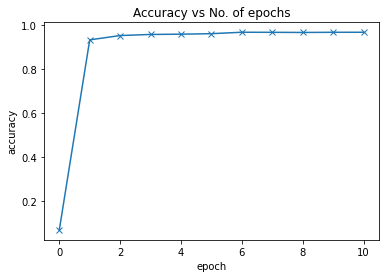

In [39]:
# Replace these values with your results
accuracies = [val_acc] + metrics1 + metrics2
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs')

In [40]:
accuracies

[0.07008333333333333,
 0.9331666666666667,
 0.95275,
 0.95775,
 0.9589166666666666,
 0.96125,
 0.96775,
 0.9674166666666667,
 0.96675,
 0.9675833333333334,
 0.9676666666666667]